<a href="https://www.kaggle.com/code/veeraj16/multi-disease-detection-model-using-cnn?scriptVersionId=253185158" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div align="center" style="padding: 10px; background-color: #3366ff; font-family: 'Times New Roman', sans-serif; color: white; font-weight: bold; border-radius: 5px;">Multi-Disease Detection Notebook 🧠|CNN| Transfer Learning</div>

In [1]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop 
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
from tensorflow.keras import regularizers
from PIL import Image
from efficientnet.tfkeras import EfficientNetB0

2025-07-29 18:37:41.828749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753814262.048511      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753814262.108570      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# <div align="center" style="padding: 10px; background-color: #3366ff;font-family: 'Times New Roman', sans-serif; color: white; font-weight: bold; border-radius: 3px;">Preprocessing & Visualization</div>

In [4]:
def load_images(folders, label_map):
    # creating two lists to store the images and labels
    images = []
    labels = []
    
    # loading the images from each folder in the dataset
    for folder in folders:
        for category in os.listdir(folder):
            category_path = os.path.join(folder, category)
            if os.path.isdir(category_path):
                if category in label_map:  # Check if the category is present in the label_map
                    label = label_map[category]
                    file_list = os.listdir(category_path)
                    for filename in file_list:
                        img_path = os.path.join(category_path, filename)
                        image = cv2.imread(img_path)
                        # resizing the images to create a standard and so that it can be suitable for the model input
                        image = cv2.resize(image, (224, 224))
                        # cv2 reads the image as BGR so we need to convert it back to RGB
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        labels.append(label)
    
    return np.array(images), np.array(labels)



In [5]:
data_folders = [
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection',
]

# encoding the labels 
label_map = {'no': 0, 'yes': 1}  # Map negative to 0 (no) and positive to 1 (yes)

images, labels = load_images(data_folders, label_map)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)


Shape of images: (253, 224, 224, 3)
Shape of labels: (253,)


## Visualizing the images with their labels

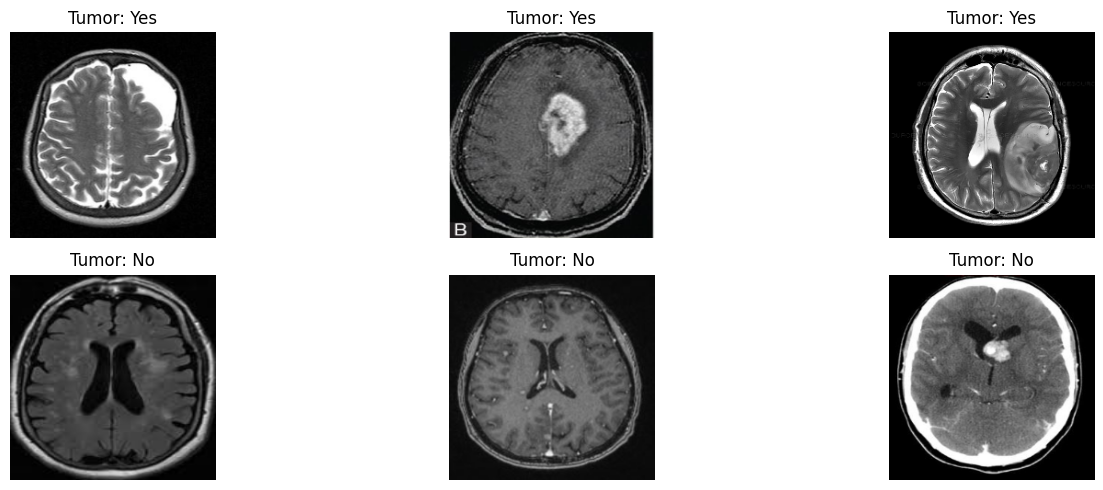

In [6]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[labels == 1][i])  # Filter images with label 'yes'
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(images[labels == 0][i])  # Filter images with label 'no'
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Labels Distribution

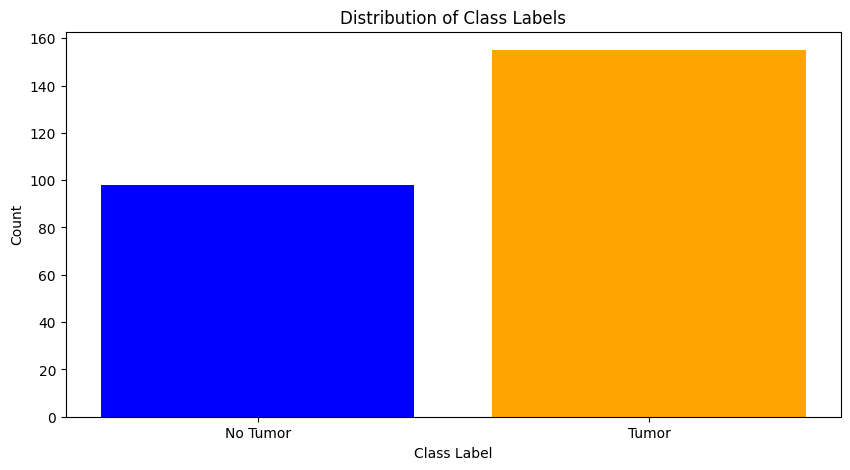

In [7]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

## Brain Cropping Function

In [8]:
def crop_brain_region(image, size):
    
    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)
    
    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)
    
    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)
    
    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]
    
    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)
    
    return contour_image, bounding_box_image, cropped_image, resized_image

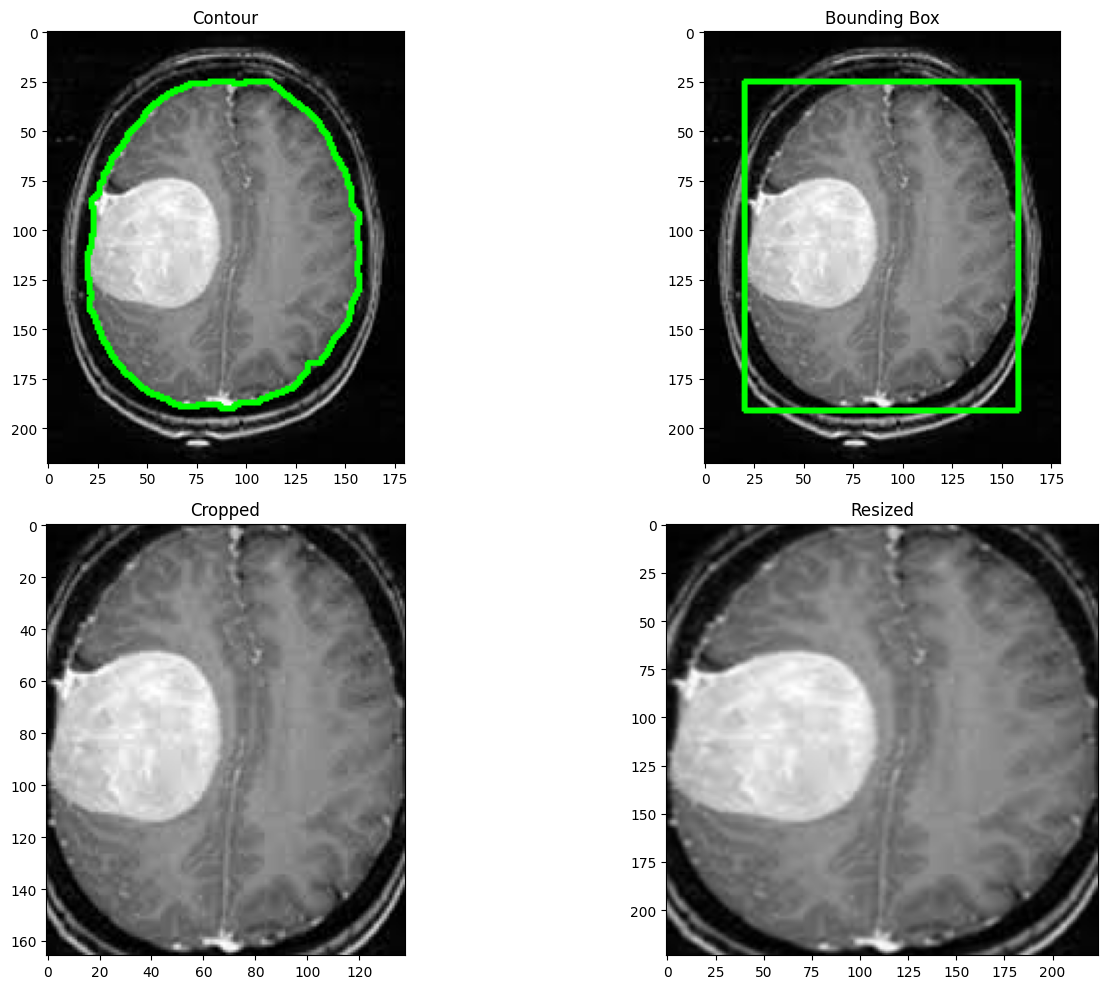

In [9]:
output_size = (224, 224)

example_image = cv2.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in images:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)


comparing images before and after cropping

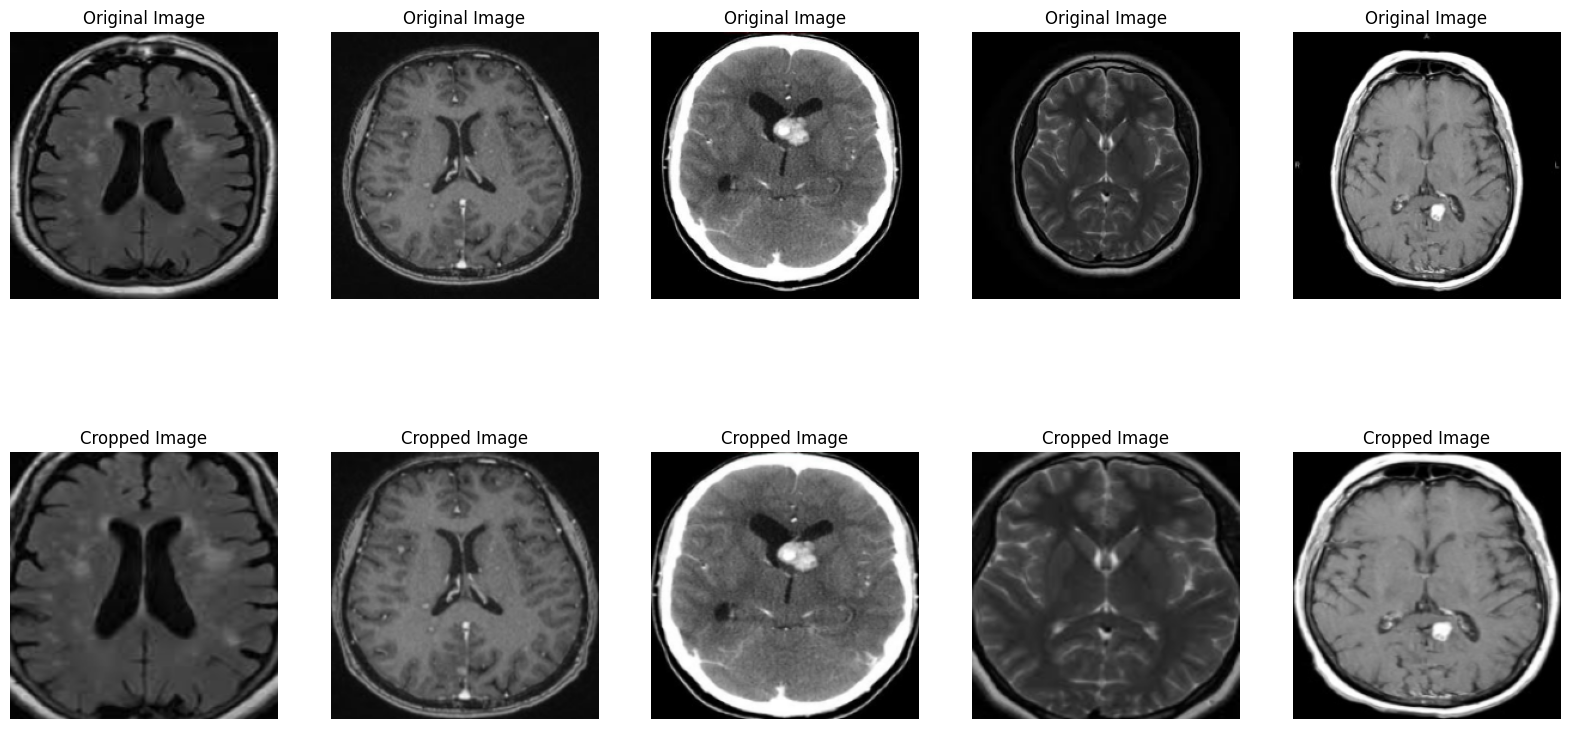

In [10]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(images[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()


# <div align="center" style="padding: 10px; background-color: #3366ff;font-family: 'Times New Roman', sans-serif; color: white; font-weight: bold; border-radius: 3px;">Data Splitting</div>

Now, we split the data into training, validation, and test sets. But first we have to transform our all_cropped list into a numpy array.

In [11]:
all_cropped=np.array(all_cropped)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(all_cropped, labels, test_size=0.2,shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: (202, 224, 224, 3)
X_val shape: (25, 224, 224, 3)
X_test shape: (26, 224, 224, 3)
y_train shape: (202,)
y_val shape: (25,)
y_test shape: (26,)


In [14]:
train_folder = 'Train'
val_folder = 'Validation'
test_folder = 'Test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

label_map_decoded = {1: 'yes', 0: 'no'}

def copy_images_to_folder(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_name = label_map_decoded[label]
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        img_filename = f'{class_name}_{i}.jpg'  # Assuming images are in JPG format
        img_path = os.path.join(class_folder, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Save image directly without converting to PIL format




In [15]:
copy_images_to_folder(X_train, y_train, train_folder)
copy_images_to_folder(X_val, y_val, val_folder)
copy_images_to_folder(X_test, y_test, test_folder)


Normalizing the images to range from [0,1] instead of [0,255] 

In [16]:
print(np.max(X_train))
print(np.min(X_train))


255
0


In [17]:
X_train_scaled=X_train/255
X_test_scaled=X_test/255
X_val_scaled=X_val/255

In [18]:
print(np.max(X_train_scaled))
print(np.min(X_train_scaled))

1.0
0.0


# <div align="center" style="padding: 10px; background-color: #3366ff;font-family: 'Times New Roman', sans-serif; color: white; font-weight: bold; border-radius: 3px;">Baseline CNN</div>

Using a simple architecture for comparison purposes

In [19]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753814285.195798      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753814285.196672      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
epochs = 50 
batch_size = 32 

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  


history = model.fit(X_train_scaled,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled,y_val),
                   callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1753814289.938289      74 service.cc:148] XLA service 0x7d10dc0039d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753814289.939293      74 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753814289.939329      74 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753814290.289935      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6111 - loss: 0.6804

I0000 00:00:1753814296.457778      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 867ms/step - accuracy: 0.6041 - loss: 0.6796 - val_accuracy: 0.6400 - val_loss: 0.6503
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6257 - loss: 0.6297 - val_accuracy: 0.6400 - val_loss: 0.6500
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6257 - loss: 0.6110 - val_accuracy: 0.6400 - val_loss: 0.6452
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6257 - loss: 0.5934 - val_accuracy: 0.6400 - val_loss: 0.6467
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6572 - loss: 0.5749 - val_accuracy: 0.6400 - val_loss: 0.6463
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6922 - loss: 0.5519 - val_accuracy: 0.6000 - val_loss: 0.6442
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7572 - loss: 0.5344 - val_accuracy: 0.6400 - val_loss: 0.6405
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7607 - loss: 0.5197 - val_accuracy: 0.5600 - val_loss: 0.6379
Epoch 9/5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
Accuracy on Validation Set: 0.760 %


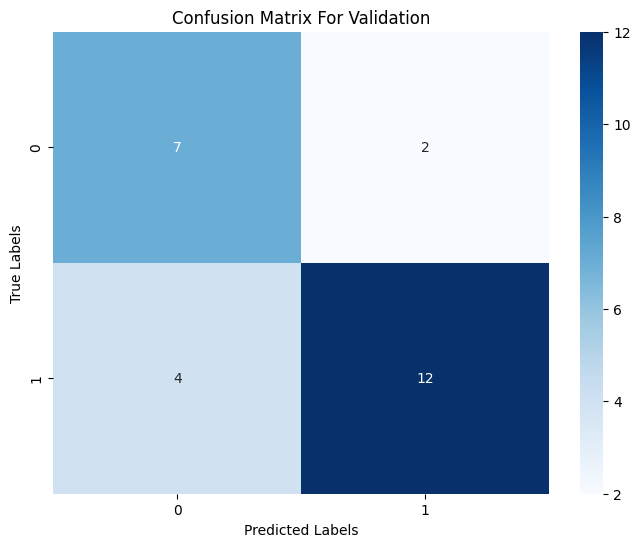

In [21]:
predictions = model.predict(X_val_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Accuracy on Test Set: 0.808 %


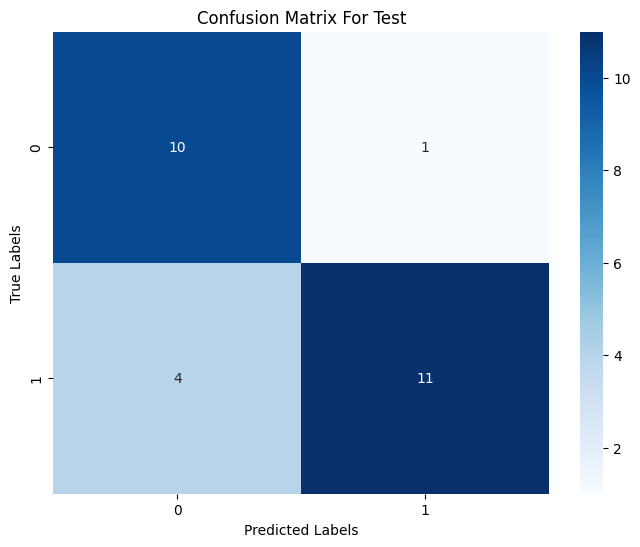

In [22]:
predictions = model.predict(X_test_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

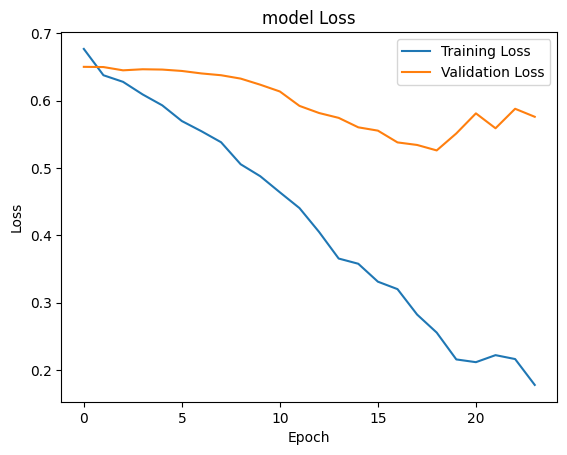

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

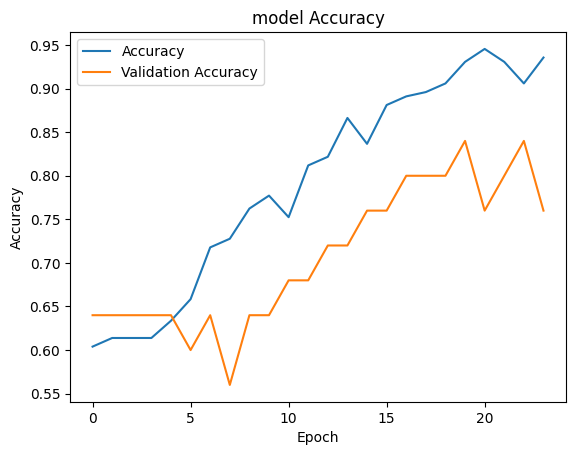

In [24]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# <div align="center" style="padding: 10px; background-color: #3366ff;font-family: 'Times New Roman', sans-serif; color: white; font-weight: bold; border-radius: 3px;">Data Augmentation</div>

Using ImageDataGenerator to perform data augmentation on the training set. This helps increase the diversity of the training data and improve the model's generalization ability.


In [25]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

image_size=(224,224)

train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,  
    class_mode='binary'
)

Found 202 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


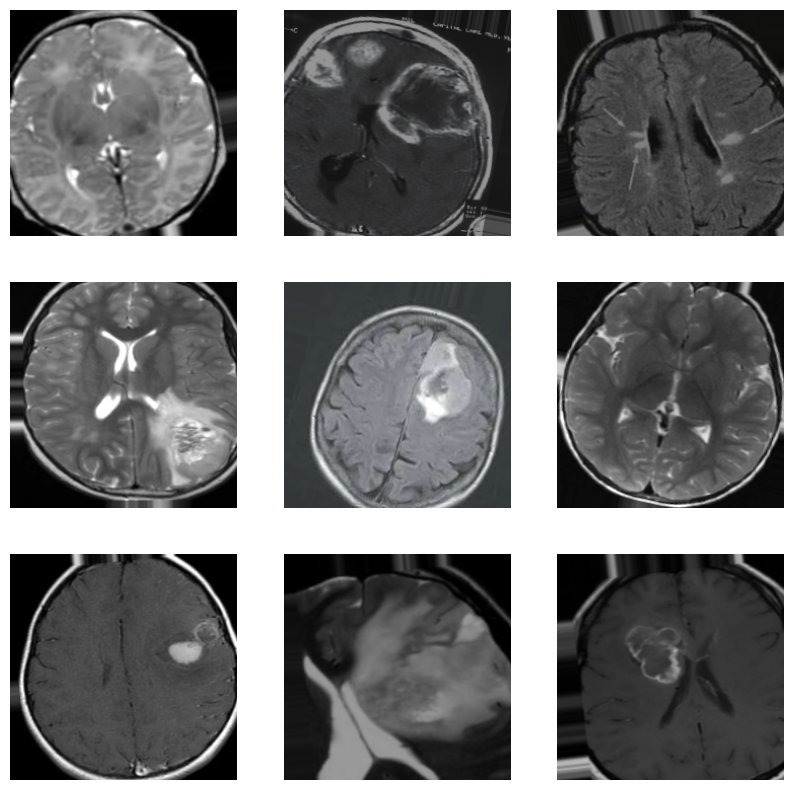

In [26]:

augmented_images, _ = next(datagen.flow(X_train, y_train, batch_size=32))

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

# <div align="center" style="padding: 10px; background-color: #3366ff;font-family: 'Times New Roman', sans-serif; color: white; font-weight: bold; border-radius: 3px;">VGG 16</div>

Using a pre-trained VGG16 model with `keras-pretrained-models` weights, because it provides a well-established convolutional neural network architecture that has been trained on a large dataset (ImageNet). By using a pre-trained model like VGG16, we can benefit from the features learned during its training on ImageNet, which includes detecting various shapes, textures, and patterns in images.

In [27]:
base_model = VGG16(weights='/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5845 - loss: 0.7237 - val_accuracy: 0.6000 - val_loss: 0.6477 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.6214 - loss: 0.6601 - val_accuracy: 0.6400 - val_loss: 0.6505 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.6476 - loss: 0.6410 - val_accuracy: 0.6400 - val_loss: 0.6259 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.6323 - loss: 0.6291 - val_accuracy: 0.6000 - val_loss: 0.6112 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.7171 - loss: 0.5534 - val_accuracy: 0.6400 - val_loss: 0.5986 - learning_rate: 1.0000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.7242 - loss: 0.5564 - val_accuracy: 0.7200 - val_loss: 0.5713 - learning_rate: 1.0000e-04
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.7542 - loss: 0.5154

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Accuracy on Validation Set: 0.880000


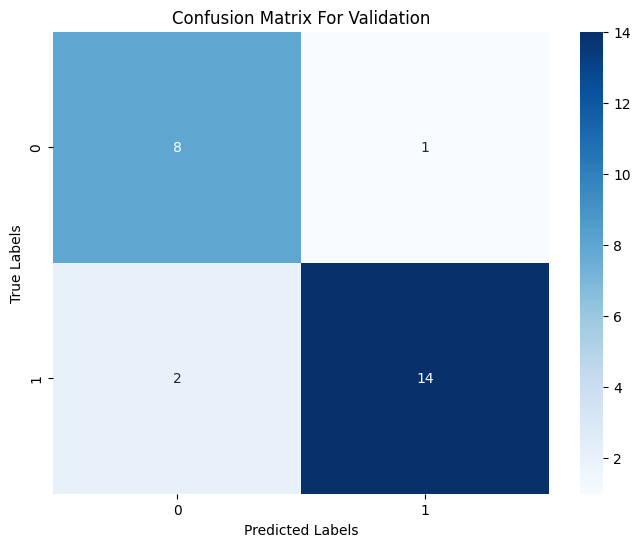

In [29]:
predictions = model.predict(X_val_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Accuracy on Test Set: 1.000000


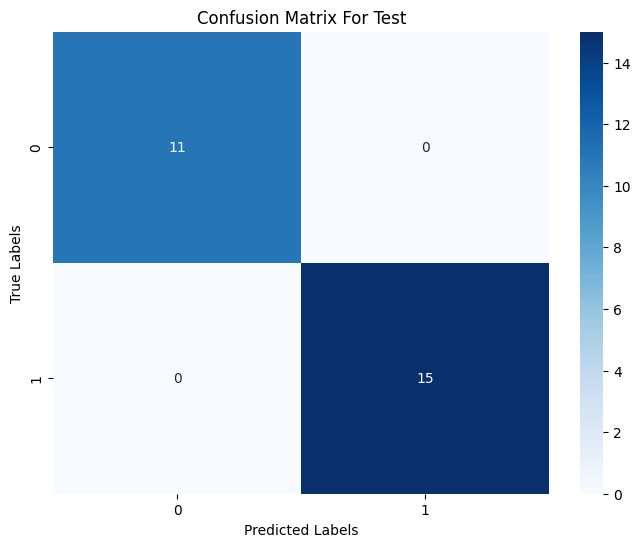

In [30]:
predictions = model.predict(X_test_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

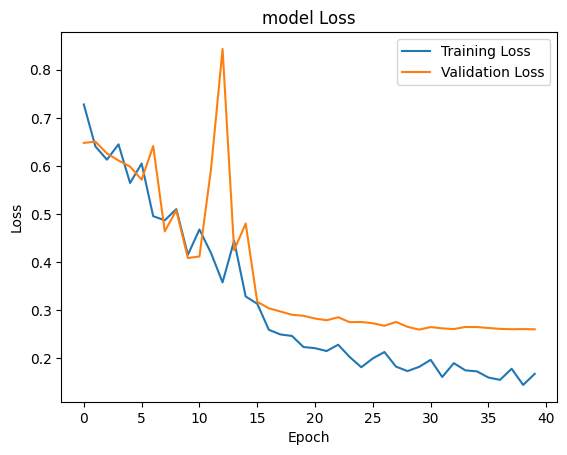

In [31]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

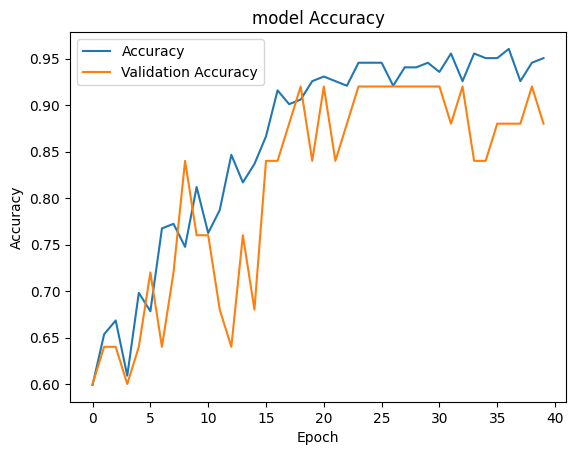

In [32]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# <div align="center" style="padding: 10px; background-color: #3366ff;font-family: 'Times New Roman', sans-serif; color: white; font-weight: bold; border-radius: 3px;">EfficientNet</div>

In [33]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4767 - loss: 0.8800 - val_accuracy: 0.5600 - val_loss: 0.6824 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5085 - loss: 0.8811 - val_accuracy: 0.7200 - val_loss: 0.6399 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6333 - loss: 0.6947 - val_accuracy: 0.8000 - val_loss: 0.6102 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6798 - loss: 0.6181 - val_accuracy: 0.8000 - val_loss: 0.5819 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7275 - loss: 0.5827 - val_accuracy: 0.8000 - val_loss: 0.5532 - learning_rate: 1.0000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7415 - loss: 0.5422 - val_accuracy: 0.8400 - val_loss: 0.5257 - learning_rate: 1.0000e-04
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8152 - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Accuracy on Validation Set: 0.880000


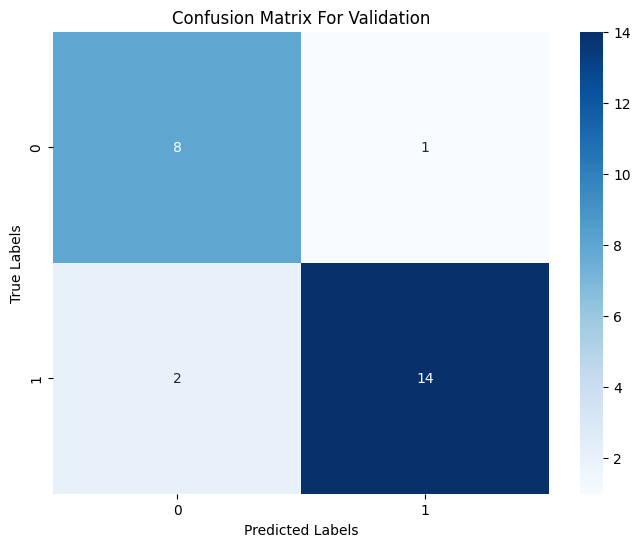

In [35]:
predictions = model.predict(X_val_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Accuracy on Test Set: 0.923077


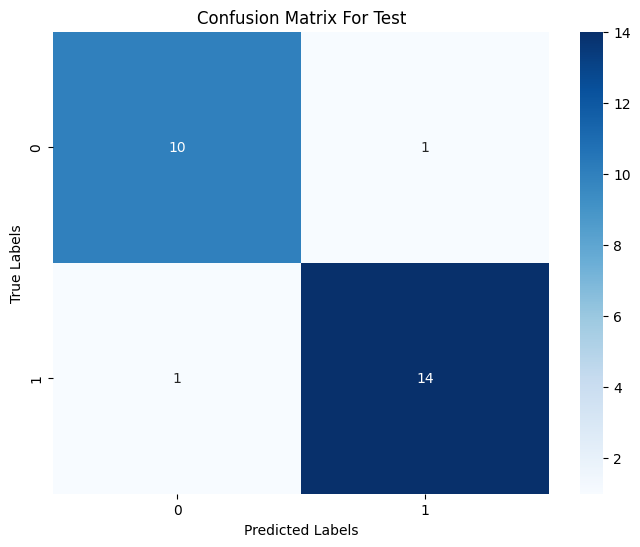

In [36]:
predictions = model.predict(X_test_scaled)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

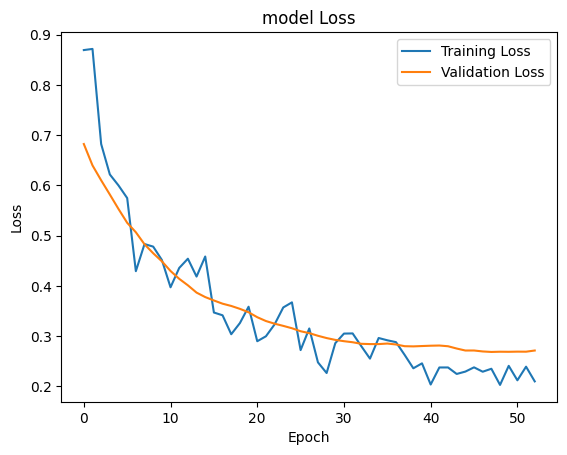

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

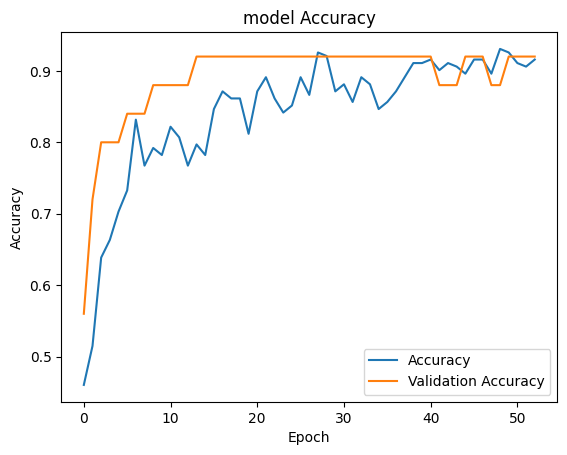

In [38]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()